# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2, l1, l1_l2
from collections import deque

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import pickle


2022-06-13 14:58:18.870519: I tensorflow/core/util/util.cc:168] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-13 14:58:18.875533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-13 14:58:18.875549: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


name convert optimizers ['fuse_bias_add', 'remove_useless_transpose', 'output_rounding_saturation_mode', 'qkeras_factorize_alpha', 'extract_ternary_threshold', 'fuse_consecutive_batch_normalization'] File: flow.py Line: 23
name optimize optimizers ['eliminate_linear_activation', 'fuse_consecutive_batch_normalization', 'fuse_batch_normalization', 'replace_multidimensional_dense_with_conv'] File: flow.py Line: 23
vivado:merge_batch_norm_quantized_tanh Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:quantize_dense_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_config_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:batchnormalizationquantizedtanh_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_output Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:clone_function_template Get_Optimizer, optimizer/optimizer.py ligne: 168
vivado:optimize_pointwise_conv Get_Optimizer, optimizer/opti

/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


## Data creation 

In [3]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()

shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


In [4]:
boosted_model =  tf.keras.models.load_model('../../pb_file')

boosted_model.summary()


2022-06-13 14:58:24.914709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-13 14:58:24.914748: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-13 14:58:24.914775: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martop): /proc/driver/nvidia/version does not exist
2022-06-13 14:58:24.915211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Settings

In [5]:
# settings of the networks 
output = 1

nbr_batch = 64
nbr_epoch = 200
lr=0.001

time_step = 5
nbr_conv_epoch = 70 #number of epochs for the conversion 

weight_decay=0.00000001
patience_es = 12
patience_rlr = 3
delta = 0.00000001
regularizer = l2

def version(v): return (v)
versions_range = 4 

def units(j): return (j+8)
units_range = 1

In [6]:
integer = 0

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+1)*2

def bit_width(i): return {'bits': (i+1)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

rest_array = [8,10,12]
rest_units_range =  3
bits_range = 7

In [7]:
# path

#path of the tested models 
def models_path(v) : return f"tests/models/optimized_model.h5" 
def predicts_path(v) : return f"tests/predicts/optimized_model.npy" 

#path of the qconverted models
def qmodels_path(i,v): return f"tests/qmodels/qmodels_conv_<{bit_lenghts(i)},{integer}>_v{version(v)}.h5"
def qpredicts_path(i,v): return f"tests/qpredicts/qmodels_conv_<{bit_lenghts(i)},{integer}>_v{version(v)}.npy"
def qpredicts_path_240(i,v): return f"tests/qpredicts_240/qmodels_conv_<{bit_lenghts(i)},{integer}>_v{version(v)}.npy"

def qmodels_path1(i): return f"tests/qmodels/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest=10.h5"
def qpredicts_path1(i, v, k): return f"tests/qpredicts_240/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest={rest_array[k]}_v{version(v)}.npy"

def qmodels_path2(i): return f"tests/qmodels/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest=12.h5"
def qpredicts_path2(i): return f"tests/qpredicts/qmodels_conv_patiencES={patience_es}_patienceRLR={patience_rlr}_mindelta{delta},rkernel<{bit_lenghts(i)},{integer}>_rest=12.npy"


#path of the qtrained models
def qtrained_models_path(j, i): return f"tests/qmodels_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.h5"
def qtrained_predicts_path(j, i):  return f"tests/qpredicts_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.npy"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"
def qrefpredicts_path (i) : return f"qpredicts_epoch={nbr_conv_epoch}/qpredicts<{bit_lenghts(i)},{integer}>.npy"

# 3. Compare the results

In [8]:
def exist(path,modeltopred):
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test))
     
    else : print(f'{path} already exists')
def exist_std(path,modeltopred):
    cut_indices = np.where(y_test > 0.24/16)[0]
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test[cut_indices]))
     
    else : print(f'{path} already exists')

## Predictions

In [9]:
model = tf.keras.models.load_model(models_path(0))      
exist(predicts_path(0), model)
ref = 'tests/ref_predicts.npy'
exist(ref, boosted_model)
std_ref = 'tests/std_ref_predicts.npy'
exist_std(std_ref, boosted_model)

for i in range(bits_range):
    for v in range (versions_range):
        

        qmodel0 = qkeras.utils.load_qmodel(qmodels_path(i,v))        
        exist(qpredicts_path(i,v), qmodel0)      
        exist_std(qpredicts_path_240(i,v), qmodel0)
"""
    qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i))        
    exist(qpredicts_path1(i), qmodel1)

    
    qmodel2 = qkeras.utils.load_qmodel(qmodels_path2(i))        
    exist(qpredicts_path2(i), qmodel2)
    qmodel3 = qkeras.utils.load_qmodel(qmodels_path3(i))        
    exist(qpredicts_path3(i), qmodel3)"""
    




tests/predicts/optimized_model.npy already exists
tests/ref_predicts.npy already exists
tests/std_ref_predicts.npy already exists
tests/qpredicts/qmodels_conv_<2,0>_v0.npy already exists
tests/qpredicts_240/qmodels_conv_<2,0>_v0.npy already exists
tests/qpredicts/qmodels_conv_<2,0>_v1.npy already exists
tests/qpredicts_240/qmodels_conv_<2,0>_v1.npy already exists
tests/qpredicts/qmodels_conv_<2,0>_v2.npy already exists
tests/qpredicts_240/qmodels_conv_<2,0>_v2.npy already exists
tests/qpredicts/qmodels_conv_<2,0>_v3.npy already exists
tests/qpredicts_240/qmodels_conv_<2,0>_v3.npy already exists
tests/qpredicts/qmodels_conv_<4,0>_v0.npy already exists
tests/qpredicts_240/qmodels_conv_<4,0>_v0.npy already exists
tests/qpredicts/qmodels_conv_<4,0>_v1.npy already exists
tests/qpredicts_240/qmodels_conv_<4,0>_v1.npy already exists
tests/qpredicts/qmodels_conv_<4,0>_v2.npy already exists
tests/qpredicts_240/qmodels_conv_<4,0>_v2.npy already exists
tests/qpredicts/qmodels_conv_<4,0>_v3.npy al

'\n    qmodel1 = qkeras.utils.load_qmodel(qmodels_path1(i))        \n    exist(qpredicts_path1(i), qmodel1)\n\n    \n    qmodel2 = qkeras.utils.load_qmodel(qmodels_path2(i))        \n    exist(qpredicts_path2(i), qmodel2)\n    qmodel3 = qkeras.utils.load_qmodel(qmodels_path3(i))        \n    exist(qpredicts_path3(i), qmodel3)'

## Plotting

[0.000872595, 1.5549076e-05, 1.1759904e-05, 1.11554955e-05, 1.08688955e-05, 1.0415346e-05, 1.0444003e-05]
[0.000872595, 1.4091482e-05, 1.3480999e-05, 1.076246e-05, 1.063127e-05, 1.181399e-05, 1.1460235e-05]
[0.000872595, 1.8674027e-05, 1.3458657e-05, 1.0821757e-05, 1.1743167e-05, 1.0691845e-05, 1.0949268e-05]
[0.000872595, 1.47295505e-05, 1.1191952e-05, 1.1397023e-05, 1.1264339e-05, 1.3348051e-05, 1.1672866e-05]


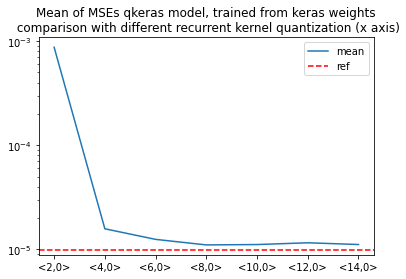

In [10]:

loss1 = [] 
loss2 = [] 
loss3 = [] 
yaxis = []
sum1=0
sum2=0
sum3=0
sum4=0
sum5=0
sum6=0
sum0=0

yaxis.append('<2,0>')
yaxis.append('<4,0>')
yaxis.append('<6,0>')
yaxis.append('<8,0>')
yaxis.append('<10,0>')
yaxis.append('<12,0>')
yaxis.append('<14,0>')
for v in range (versions_range):

    loss1 = [] 
    y_kerasref = np.load(predicts_path(0))
    y_keras0 = np.load(qpredicts_path(0,v))
    y_keras1 = np.load(qpredicts_path(1,v))
    y_keras2 = np.load(qpredicts_path(2,v))
    y_keras3 = np.load(qpredicts_path(3,v))
    y_keras4 = np.load(qpredicts_path(4,v))
    y_keras5 = np.load(qpredicts_path(5,v))
    y_keras6 = np.load(qpredicts_path(6,v))


    sum0= sum0+mse(y_test,y_keras0)
    sum1= sum1+mse(y_test,y_keras1)
    sum2= sum2+mse(y_test,y_keras2)
    sum3= sum3+mse(y_test,y_keras3)
    sum4= sum4+mse(y_test,y_keras4)
    sum5= sum5+mse(y_test,y_keras5)
    sum6= sum6+mse(y_test,y_keras6)

    
    loss1.append(mse(y_test,y_keras0))   
    loss1.append(mse(y_test,y_keras1))
    loss1.append(mse(y_test,y_keras2))        
    loss1.append(mse(y_test,y_keras3))     
    loss1.append(mse(y_test,y_keras4))     
    loss1.append(mse(y_test,y_keras5))  
    loss1.append(mse(y_test,y_keras6)) 
    #
    #plt.plot(loss1,'+')
    print(loss1)

loss2.append((sum0/versions_range))
loss2.append((sum1/versions_range))
loss2.append((sum2/versions_range))
loss2.append((sum3/versions_range))
loss2.append((sum4/versions_range))
loss2.append((sum5/versions_range))
loss2.append((sum6/versions_range))


plt.yscale('log')
plt.plot(loss2)
#plt.legend(['bench 1','bench 2','bench 3','mean'])
plt.title(f'Mean of MSEs qkeras model, trained from keras weights\n comparison with different recurrent kernel quantization (x axis)')
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')
plt.legend(['mean','ref'])


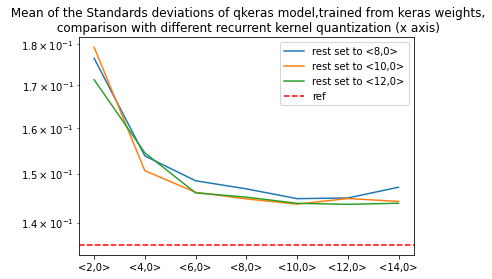

In [63]:
yaxis=[]
yaxis.append('<2,0>')
yaxis.append('<4,0>')
yaxis.append('<6,0>')
yaxis.append('<8,0>')
yaxis.append('<10,0>')
yaxis.append('<12,0>')
yaxis.append('<14,0>')

cut_indices = np.where(y_test > 0.24/16)[0]
preds = np.load(std_ref)
cut_y = y_test[cut_indices]
reso = preds - cut_y
ref_stdev = np.std(reso*16)

for k in range (rest_units_range):
    std=[]
    for i in range(bits_range):
        stdev_mean=0
        for v in range (versions_range):
            cut_indices = np.where(y_test > 0.24/16)[0]
            preds = np.load(qpredicts_path1(i,v,k))
            cut_y = y_test[cut_indices]
            reso = preds - cut_y
            stdev = np.std(reso*16)
            stdev_mean=stdev_mean+stdev
        std.append(stdev_mean/versions_range)
    plt.plot(std)
#plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')
plt.axhline(ref_stdev, linestyle="--", color = 'red')
plt.legend(['rest set to <8,0>','rest set to <10,0>','rest set to <12,0>','ref'])
plt.title(f' Mean of the Standards deviations of qkeras model,trained from keras weights,\n comparison with different recurrent kernel quantization (x axis)')
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
plt.yscale('log')
plt.show()

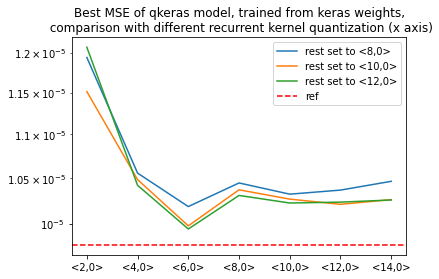

In [64]:
yaxis=[]
yaxis.append('<2,0>')
yaxis.append('<4,0>')
yaxis.append('<6,0>')
yaxis.append('<8,0>')
yaxis.append('<10,0>')
yaxis.append('<12,0>')
yaxis.append('<14,0>')

for k in range (rest_units_range):
    loss=[]
    for i in range(bits_range):
        best_mse=100
        for v in range (versions_range):
            y_keras0 = np.load(qpredicts_path0(i,v,k))
            tmp_mse = mse(y_test,y_keras0)
            if (best_mse>tmp_mse): best_mse=tmp_mse
        loss.append(best_mse)
    plt.plot(loss)
plt.axhline(mse(y_test, np.load(ref)), linestyle="--", color = 'red')
plt.legend(['rest set to <8,0>','rest set to <10,0>','rest set to <12,0>','ref'])
plt.title(f'Best MSE of qkeras model, trained from keras weights,\n comparison with different recurrent kernel quantization (x axis)')
plt.xticks(np.arange(len(yaxis)), [f"{Bit}" for Bit in yaxis])
plt.yscale('log')
plt.show()